In [6]:
import pandas as pd
import mplfinance as mpf

In [1]:
import rbot

In [2]:
bb = rbot.DummyBb()
bb.log_load(180)


In [7]:
def array_to_df(array):
    ohlcv_df = pd.DataFrame(array, columns=["timestamp", "open", "high", "low", "close", "volume"]) 
    ohlcv_df['timestamp'] = pd.to_datetime((ohlcv_df["timestamp"]), utc=True, unit='ms')
    ohlcv_df = ohlcv_df.set_index('timestamp')

    return ohlcv_df
    

In [8]:
ohlcv = bb.ohlcv(0, bb.log_end_ms, 60*60 * 2)

ohlcv_df = array_to_df(ohlcv)





In [9]:
rbot.PrintTime(bb.log_end_ms)

'2022-06-25-23:59:59.000'

In [10]:
ohlcv_df

,open,high,low,close,volume
timestamp,,,,,
2021-12-28 00:00:00+00:00,50706.5,50707.0,49641.0,49840.0,336531578.0
2021-12-28 02:00:00+00:00,49839.5,49934.0,49506.0,49804.0,177238158.0
2021-12-28 04:00:00+00:00,49804.5,49804.5,48510.0,49197.5,398253272.0
2021-12-28 06:00:00+00:00,49197.0,49350.0,49039.0,49217.0,106926643.0
2021-12-28 08:00:00+00:00,49217.5,49420.0,49001.0,49022.0,145798479.0
...,...,...,...,...,...
2022-06-25 14:00:00+00:00,21139.5,21200.0,20872.0,20939.5,66100077.0
2022-06-25 16:00:00+00:00,20940.0,21136.5,20889.0,21070.0,40241141.0
2022-06-25 18:00:00+00:00,21070.0,21234.0,21014.0,21185.0,34720290.0


/opt/homebrew/lib/python3.9/site-packages/mplfinance/_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


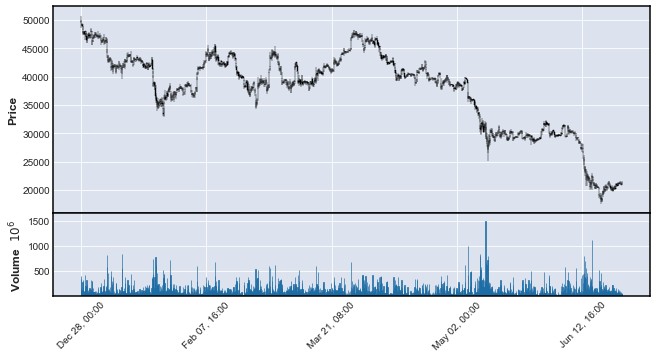

In [11]:

mpf.plot(ohlcv_df, type='candle', volume=True, figratio=(16,8))





In [19]:
class Agent:
    def __init__(self):
            self.K = 1.6                            # パラメターKを設定する。
            self.detect_long = False
            self.detect_short = False

    def on_event(self, time_ms, action, price, size):
        if self.detect_long:
            self.detect_long = False
            print(rbot.PrintTime(time_ms), "Long", price)
        
        if self.detect_short:
            self.detect_short = False
            print(rbot.PrintTime(time_ms), "short", price)


    def on_tick(self, time_ms, session):
        ohlcv_array = session.ohlcv(60*60*2, 6)     # 最新足０番目　＋　５本の足を取得。 最新は６番目。
        ohlcv_df = array_to_df(ohlcv_array)         # ndarrayをDataFrameへ変換

        if len(ohlcv_df.index) < 6:                 # データがかこ６本分そろっていない場合はリターン
            return 

        ohlcv_df["range"] = ohlcv_df["high"] - ohlcv_df["low"]      # レンジを計算

        ohlcv_latest = ohlcv_df[-2:-1]     # 最新足１本
        ohlcv_last_5 = ohlcv_df[:-2]       # 過去５本足

        range_width = ohlcv_last_5["range"].mean()      #　過去５本足のレンジの平均値

        # Long/Short判定
        self.detect_short = range_width * self.K < ohlcv_latest["high"].mean() - ohlcv_latest["open"].mean()
        self.detect_long  = range_width * self.K < ohlcv_latest["open"].mean() - ohlcv_latest["low"].mean()

    
    def on_update(self, result):
        print("update", result.status)


In [20]:
agent = Agent()

In [23]:
bb.run(agent, 60*60*1)

call back tick by 3600[sec]
call back by update
call back by all log events
2021-12-28-17:00:00.000 Long 48599.5
2021-12-28-18:00:00.000 Long 48026.0
2021-12-28-19:00:00.000 Long 47800.0
2021-12-28-20:00:00.000 Long 47686.0
2021-12-29-15:00:00.000 Long 47832.0
2021-12-29-16:00:00.000 Long 47975.0
2021-12-30-01:00:00.000 Long 46651.0
2021-12-30-02:00:00.000 Long 46559.5
2021-12-30-13:00:00.000 short 47525.0
2021-12-30-14:00:00.000 short 47342.0
2021-12-31-11:00:00.000 short 48003.0
2021-12-31-12:00:00.000 short 47980.0
2021-12-31-19:00:00.000 Long 46649.0
2021-12-31-20:00:00.000 Long 45686.5
2021-12-31-21:00:00.000 Long 45849.5
2021-12-31-22:00:00.000 Long 46299.5
2022-01-02-19:00:00.000 short 47051.5
2022-01-02-20:00:00.000 short 46915.5
2022-01-02-21:00:01.000 Long 47014.0
2022-01-02-22:00:00.000 Long 46997.5
2022-01-04-21:00:00.000 Long 46248.5
2022-01-04-22:00:00.000 Long 46200.0
2022-01-05-13:00:01.000 Long 46193.0
2022-01-05-14:00:00.000 Long 46405.5
2022-01-05-21:00:00.000 Long 4

In [49]:
tr = bb.transactions

In [50]:
import pandas as pd

In [51]:
for item in tr:
    print(item)

In [35]:
timestamp = []
order_id = []
order_sub_id = []
order_type = []
post_only = []
create_time = []
status = []
open_price = []
close_price = []
size = []
volume = []
profit = []
fee = []
total_profit = []
message = []

for item in tr:
    timestamp.append(item.timestamp)
    order_id.append(item.order_id)
    order_sub_id.append(item.order_sub_id)
    order_type.append(item.order_type)
    post_only.append(item.post_only)
    create_time.append(item.create_time)
    status.append(item.status)
    open_price.append(item.open_price)
    close_price.append(item.close_price)
    size.append(item.size)
    volume.append(item.volume)
    profit.append(item.profit)
    fee.append(item.fee)
    total_profit.append(item.total_profit)
    message.append(item.message)





In [36]:
df = pd.DataFrame(
data = {"timestamp": timestamp, "order_id": order_id, "sub_id": order_sub_id, 
"order_type": order_type, "post_only": post_only, "create_time": create_time,
"status":  status, "open_price": open_price, "close_price": close_price, 
"size": size, "volume": volume, "profit": profit, "fee": fee,
"total_profit":total_profit, "message": message},
columns = ["timestamp", "order_id", "sub_id", "order_type", "post_only",
"create_time", "status", "open_price", "close_price","size", "volume", 
"profit", "fee","total_profit", "message"]
)
df["timestamp"] = pd.to_datetime((df["timestamp"]), utc=True, unit='ms')
df["create_time"] = pd.to_datetime((df["create_time"]), utc=True, unit='ms')


In [37]:
df

,timestamp,order_id,sub_id,order_type,post_only,create_time,status,open_price,close_price,size,volume,profit,fee,total_profit,message


In [19]:
global_ohlcv

NameError: name 'global_ohlcv' is not defined

In [43]:
#index = range(len(agent.ohlcv))
ohlcv_df = pd.DataFrame(agent.ohlcv, columns=["timestamp", "open", "high", "low", "close", "vol"]) #index=index))
ohlcv_df['timestamp'] = pd.to_datetime((ohlcv_df["timestamp"]), utc=True, unit='ms')
#ohlcv_df = df.sort_values("timestamp", ascending=False)



In [40]:
ohlcv_df

,timestamp,open,high,low,close,vol
0,2022-06-23 23:58:00+00:00,21096.5,21096.5,21073.0,21073.0,578182.0
1,2022-06-23 23:57:00+00:00,21075.0,21100.0,21075.0,21097.0,361443.0
2,2022-06-23 23:56:00+00:00,21077.5,21080.0,21075.0,21075.0,179245.0
3,2022-06-23 23:55:00+00:00,21069.0,21080.5,21069.0,21077.0,158544.0
4,2022-06-23 23:54:00+00:00,21070.5,21079.0,21068.5,21069.0,316112.0
...,...,...,...,...,...,...
95,2022-06-23 22:23:00+00:00,20818.5,20861.0,20815.0,20850.5,906002.0
96,2022-06-23 22:22:00+00:00,20800.5,20831.5,20800.5,20818.0,778014.0
97,2022-06-23 22:21:00+00:00,20797.0,20804.5,20790.0,20797.0,533457.0
98,2022-06-23 22:20:00+00:00,20815.0,20817.0,20790.5,20793.5,1912237.0


In [28]:
ohlcv_df["timestamp"]%1_000_00000

0     28680000.0
1     28620000.0
2     28560000.0
3     28500000.0
4     28440000.0
         ...    
95    22980000.0
96    22920000.0
97    22860000.0
98    22800000.0
99    22740000.0
Name: timestamp, Length: 100, dtype: float64